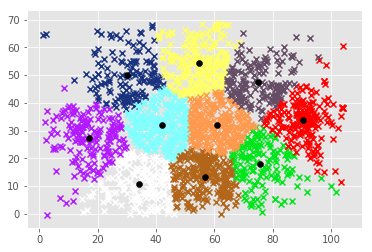

In [2]:
import math
import json
import pandas as pd
import numpy as np
from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt



style.use('ggplot')

with open('data/general/matches_2017_2018_v1.json') as matches_json:
    matches = pd.read_json(matches_json)

matches = [60565]
m_len = len(matches)

no_team = 0
home_team = 0
away_team = 0
m_id = 0

for id in matches:

    with open('data/match_' + str(id) + '/match_data_' + str(id) + '.json', 'r') as file:
            teams = json.load(file)

    referee_id = ''
    home_team_id = int(teams[1]['teamId'])
    away_team_id = int(teams[2]['teamId'])
    home_team_player = []
    away_team_player = []
        
    team_dict = {}
    team_dict[0] = 0
    team_dict[home_team_id] = 1
    team_dict[away_team_id] = 2

    home_team_pos_dict = {}
    away_team_pos_dict = {}


    data_height = 5400
    data_width = 87
    label_team_width = 3
    label_player_width = 29
    x_home_data = [[42, 56]]
    x_away_data = [[42, 56]]


    with open('data/match_' + str(id) + '/roster_data_' + str(id) + '.json', 'r') as file:
        match_squad = json.load(file)


    for roaster in match_squad:
        if roaster['teamId'] == home_team_id:
            home_team_pos_dict[roaster['jerseyNumber']] = roaster['positionId']
        elif roaster['teamId'] == away_team_id:
            away_team_pos_dict[roaster['jerseyNumber']] = roaster['positionId']
            

    with open('data/match_' + str(id) + '/per_sec_data_' + str(id) + '.json', 'r') as file:
        data_persec = json.load(file)           

    for d in data_persec:
        
        i = int(d['minute'])*60 + int(d['second'])
        x_pos = d['xpos']
        y_pos = d['ypos']
        team_id_t = int(d['teamId'])
        jersey_number_t = int(d['jerseyNumber'])
        
        
        if i>0 and i<5460 and x_pos!=0 and y_pos!=0:    
            if team_id_t == home_team_id:
                if home_team_pos_dict[jersey_number_t] !=1:
                    
                    x_home_data.append([x_pos, y_pos])
            elif team_id_t == away_team_id:
                if away_team_pos_dict[jersey_number_t] !=1:
                    x_away_data.append([x_pos, y_pos])
                    


with open('data/general/home_teamm_pos_data.npy', 'wb') as file:
    np.save(file, x_home_data)

with open('data/general/away_teamm_pos_data.npy', 'wb') as file:
    np.save(file, x_away_data)

data_height_home = len(x_home_data)
data_height_away = len(x_away_data)



x_home_data_small = [[42, 56]]
x_away_data_small = [[42, 56]]



for i in range(1,2000):
    index = np.random.randint(1,len(x_home_data))
    x_home_data_small.append([x_home_data[index][0], x_home_data[index][1]])
    x_away_data_small.append([x_away_data[index][0], x_away_data[index][1]])


x_home_data_small = np.array(x_home_data_small)
x_away_data_small = np.array(x_away_data_small)

colors = 10*[(0.1, 0.2, 0.5), (0.0, 0.9, 0.1), (0.5, 1.0, 1.0), (1.0, 1.0, 1.0),(0.7, 0.1, 1.0),
             (0.7, 0.4, 0.1), (1.0, 1.0, 0.4), (1.0, 0.6, 0.3), 
(1.0, 0.0, 0.0), (0.4,0.3,0.4)]


class K_Means:
    def __init__(self,k=10,tol=0.0001, max_iter=100):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self,data):

        self.centroids = {}

        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)

            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification], axis=0)

            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    optimized = False

            if optimized:
                break

    def predict(self, data):
        distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification


clf = K_Means()
clf.fit(x_away_data_small)


for classification in clf.classifications:
    dcolor = colors[classification]
    for featureset in clf.classifications[classification]:
        plt.scatter(featureset[0], featureset[1], marker="x", color=dcolor, linewidths=0.5)

for centroid in clf.centroids:
    plt.scatter(clf.centroids[centroid][0], clf.centroids[centroid][1],
                marker="o", color="k", linewidths=0.5)




plt.show()       


The figure above depicts the average formation of the away-team during game utilizing the k-means algorithm.
Note: Goalkeeper data isn't included. Atacking direction is along the horizontal axis